In [1]:
import os
import shutil
from PIL import Image
import numpy as np
import hashlib

# Original (read-only)
INPUT_TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"
INPUT_TEST_PATH  = "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test"

# Working (writable)
WORKING_DIR = "/kaggle/working/deepfake_cleaned"
TRAIN_PATH = os.path.join(WORKING_DIR, "train")
TEST_PATH  = os.path.join(WORKING_DIR, "test")

CLASSES = ["real", "fake"]
def copy_dataset(src, dst):
    """
    Copies dataset from read-only input to writable working directory.
    """
    if not os.path.exists(dst):
        shutil.copytree(src, dst)
        print(f"✔ Dataset copied from {src} to {dst}")
    else:
        print(f"✔ Dataset already exists at {dst}")

copy_dataset(INPUT_TRAIN_PATH, TRAIN_PATH)
copy_dataset(INPUT_TEST_PATH, TEST_PATH)
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")
def remove_exact_duplicates(dataset_path):
    hashes = {}
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            with open(file_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in hashes:
                os.remove(file_path)
                removed += 1
            else:
                hashes[file_hash] = file_path

    print(f"✔ Removed {removed} duplicate images from {dataset_path}")
def remove_corrupted_images(dataset_path):
    removed = 0

    for label in CLASSES:
        class_path = os.path.join(dataset_path, label)

        if not os.path.exists(class_path):
            continue

        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)

            try:
                with Image.open(file_path) as img:
                    img.verify()
            except Exception:
                os.remove(file_path)
                removed += 1

    print(f"✔ Removed {removed} corrupted images from {dataset_path}")

remove_corrupted_images(TRAIN_PATH)
remove_corrupted_images(TEST_PATH)

remove_exact_duplicates(TRAIN_PATH)
remove_exact_duplicates(TEST_PATH)


✔ Dataset copied from /kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train to /kaggle/working/deepfake_cleaned/train
✔ Dataset copied from /kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test to /kaggle/working/deepfake_cleaned/test
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/train
✔ Removed 0 corrupted images from /kaggle/working/deepfake_cleaned/test
✔ Removed 3 duplicate images from /kaggle/working/deepfake_cleaned/train
✔ Removed 1 duplicate images from /kaggle/working/deepfake_cleaned/test


In [2]:
import os

TRAIN_PATH = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"

classes = [
    d for d in os.listdir(TRAIN_PATH)
    if os.path.isdir(os.path.join(TRAIN_PATH, d))
]

print("Detected classes:", classes)


Detected classes: ['fake', 'real']


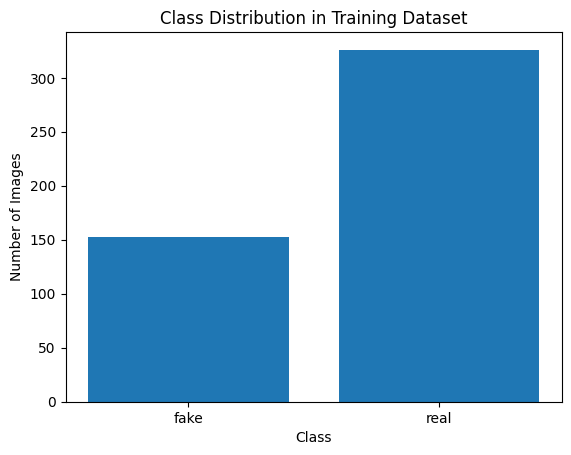

In [3]:
import matplotlib.pyplot as plt

counts = []
for label in classes:
    class_path = os.path.join(TRAIN_PATH, label)
    counts.append(len(os.listdir(class_path)))

plt.figure()
plt.bar(classes, counts)
plt.title("Class Distribution in Training Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


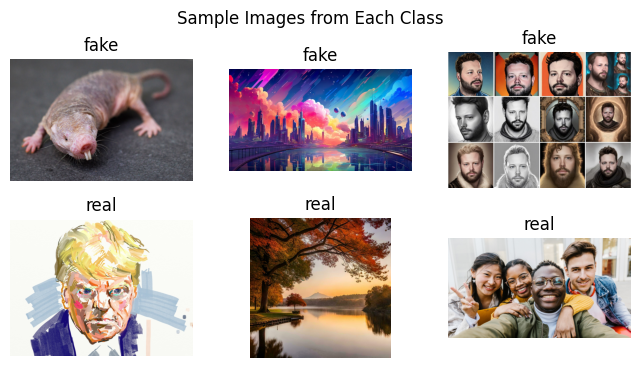

In [4]:
import random
from PIL import Image
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
idx = 1

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    samples = random.sample(os.listdir(folder), 3)

    for img_name in samples:
        img = Image.open(os.path.join(folder, img_name))
        plt.subplot(len(classes), 3, idx)
        plt.imshow(img)
        plt.title(label)
        plt.axis("off")
        idx += 1

plt.suptitle("Sample Images from Each Class")
plt.show()


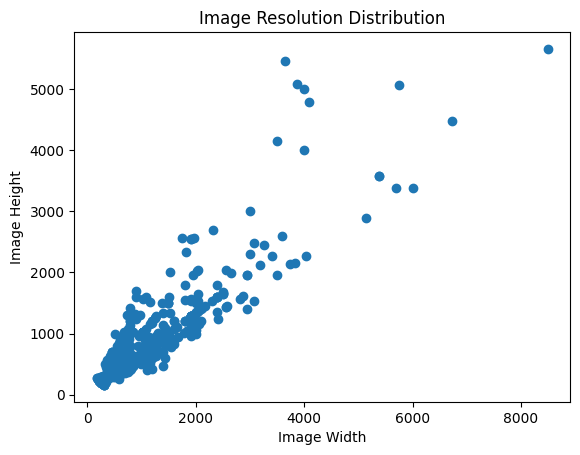

In [5]:
widths, heights = [], []

for label in classes:
    folder = os.path.join(TRAIN_PATH, label)
    for img_name in os.listdir(folder):
        img = Image.open(os.path.join(folder, img_name))
        w, h = img.size
        widths.append(w)
        heights.append(h)

plt.figure()
plt.scatter(widths, heights)
plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Resolution Distribution")
plt.show()


In [6]:
import os
import hashlib

def find_exact_duplicates(root_dir):
    hashes = {}
    duplicates = []

    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                path = os.path.join(root, file)
                with open(path, "rb") as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()

                if file_hash in hashes:
                    duplicates.append((hashes[file_hash], path))
                else:
                    hashes[file_hash] = path

    return duplicates

In [7]:
DATASET_PATH = "/kaggle/working/deepfake_cleaned"
duplicates = find_exact_duplicates(DATASET_PATH)

print("Exact duplicates found:", len(duplicates))
for dup in duplicates[:5]:
    print(dup)

Exact duplicates found: 0


In [8]:
import os
from PIL import Image, ImageOps
import numpy as np

def letterbox_preprocessing(image_path, target_size=(294, 294)):
    """
    Preprocesses an image using the 'Letterbox' method:
    1. Pads the image to make it square without distortion.
    2. Resizes it to the target size (294x294 for Xception).
    """
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2
        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        img_padded = ImageOps.expand(img, padding, fill=(0, 0, 0))
        img_resized = img_padded.resize(target_size, Image.Resampling.LANCZOS)
        return img_resized
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def process_dataset_folder(root_folder, output_folder, target_size=(294, 294)):
    """
    Processes all images in a root folder containing 'real' and 'fake' subfolders.
    """
    classes = ['real', 'fake']
    
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        
    for label in classes:
        input_class_path = os.path.join(root_folder, label)
        output_class_path = os.path.join(output_folder, label)
        
        if not os.path.exists(input_class_path):
            print(f"Skipping {label}: Folder not found in {root_folder}")
            continue
            
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)
            
        files = [f for f in os.listdir(input_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        print(f"Processing {len(files)} images in {root_folder}/{label}...")
        
        for file_name in files:
            input_path = os.path.join(input_class_path, file_name)
            output_path = os.path.join(output_class_path, file_name)
            
            processed_img = letterbox_preprocessing(input_path, target_size)
            if processed_img:
                processed_img.save(output_path)
    print(f"✔ Finished processing {root_folder} -> {output_folder}")

# Corrected paths to use the cleaned data
CLEANED_DIR = "/kaggle/working/deepfake_cleaned"
CLEANED_TRAIN = os.path.join(CLEANED_DIR, "train")
CLEANED_TEST  = os.path.join(CLEANED_DIR, "test")

PREPROCESSED_DIR = "/kaggle/working/deepfake_preprocessed"
TRAIN_OUT = os.path.join(PREPROCESSED_DIR, "train")
TEST_OUT  = os.path.join(PREPROCESSED_DIR, "test")

print("Starting batch preprocessing from cleaned data...")
process_dataset_folder(CLEANED_TRAIN, TRAIN_OUT)
process_dataset_folder(CLEANED_TEST, TEST_OUT)


Starting batch preprocessing from cleaned data...
Processing 326 images in /kaggle/working/deepfake_cleaned/train/real...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Processing 150 images in /kaggle/working/deepfake_cleaned/train/fake...
✔ Finished processing /kaggle/working/deepfake_cleaned/train -> /kaggle/working/deepfake_preprocessed/train
Processing 110 images in /kaggle/working/deepfake_cleaned/test/real...
Processing 388 images in /kaggle/working/deepfake_cleaned/test/fake...
✔ Finished processing /kaggle/working/deepfake_cleaned/test -> /kaggle/working/deepfake_preprocessed/test


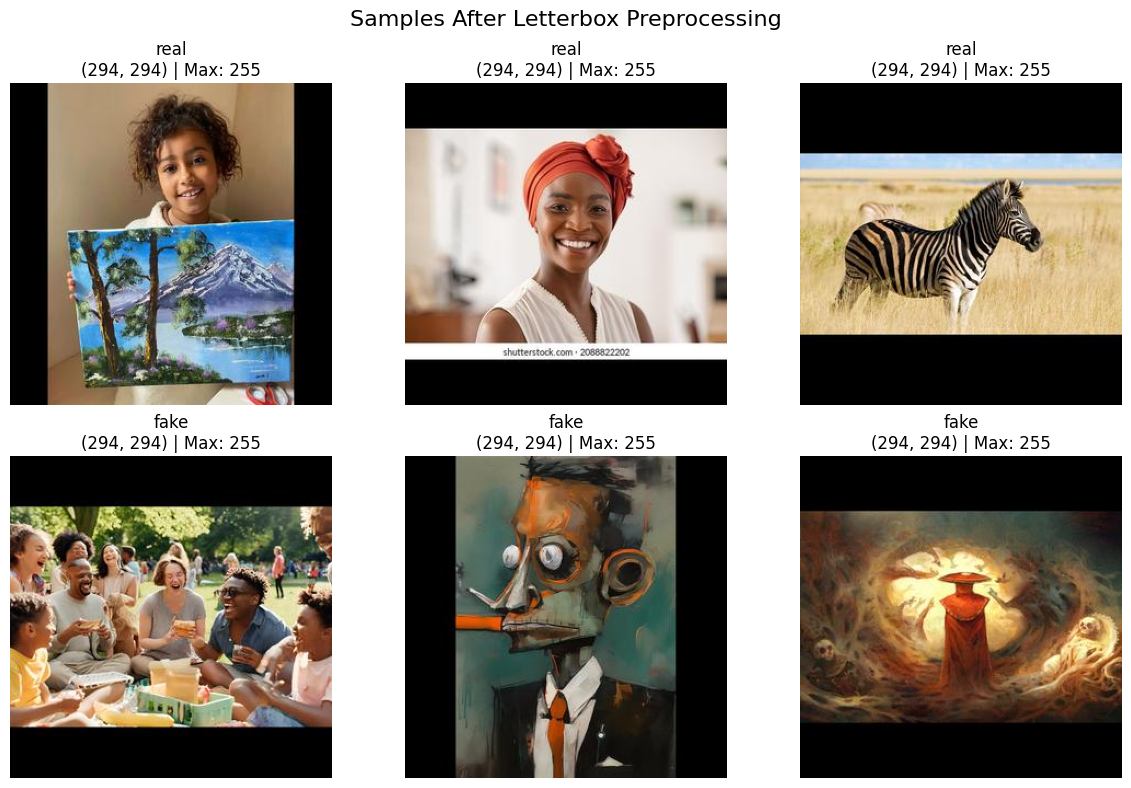

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

def visualize_preprocessed_samples(base_path, num_samples=3):
    classes = ['real', 'fake']
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(12, 8))
    
    for i, label in enumerate(classes):
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder): continue
        
        samples = random.sample(os.listdir(folder), min(num_samples, len(os.listdir(folder))))
        
        for j, img_name in enumerate(samples):
            img_path = os.path.join(folder, img_name)
            img = Image.open(img_path)
            img_array = np.array(img)
            
            axes[i, j].imshow(img)
            axes[i, j].set_title(f"{label}\n{img.size} | Max: {img_array.max()}")
            axes[i, j].axis('off')
            
    plt.suptitle("Samples After Letterbox Preprocessing", fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualize the training output
visualize_preprocessed_samples(TRAIN_OUT)


Total Images Analyzed: 476
Potential Dark Outliers: 8
Potential Blank/Low Contrast Outliers: 0


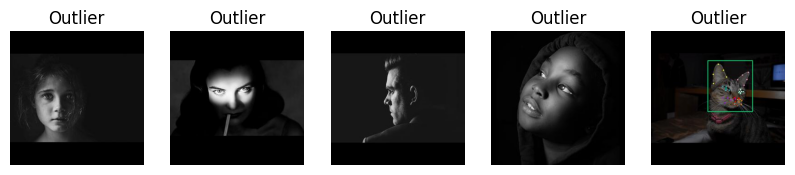

In [10]:
def analyze_outliers(base_path):
    stats = []
    paths = []
    
    for label in ['real', 'fake']:
        folder = os.path.join(base_path, label)
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = np.array(Image.open(img_path)).astype(np.float32) / 255.0
            
            # Calculate mean brightness and standard deviation (contrast)
            stats.append([np.mean(img), np.std(img)])
            paths.append(img_path)
            
    stats = np.array(stats)
    means = stats[:, 0]
    stds = stats[:, 1]
    
    # Define outliers: Brightness < 0.1 (too dark) or Std < 0.05 (low contrast/blank)
    dark_outliers = np.where(means < 0.1)[0]
    blank_outliers = np.where(stds < 0.05)[0]
    
    print(f"Total Images Analyzed: {len(paths)}")
    print(f"Potential Dark Outliers: {len(dark_outliers)}")
    print(f"Potential Blank/Low Contrast Outliers: {len(blank_outliers)}")
    
    # Visualize a few outliers if they exist
    all_outliers = list(set(dark_outliers) | set(blank_outliers))
    if all_outliers:
        plt.figure(figsize=(10, 4))
        for i, idx in enumerate(all_outliers[:5]):
            plt.subplot(1, 5, i+1)
            plt.imshow(Image.open(paths[idx]))
            plt.title("Outlier")
            plt.axis('off')
        plt.show()
    else:
        print("No significant statistical outliers detected!")

analyze_outliers(TRAIN_OUT)


Analyzing images for visualization...


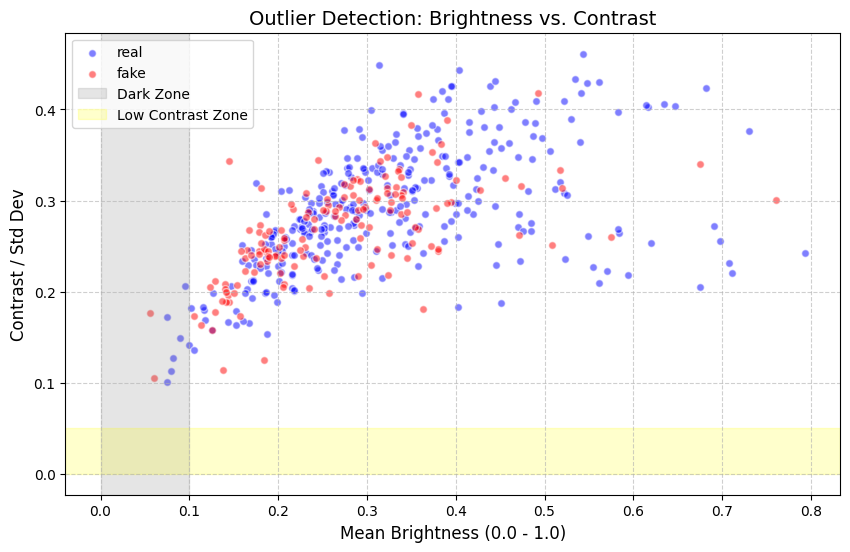

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

def plot_outlier_graph(base_path):
    means = []
    stds = []
    labels = []
    
    print("Analyzing images for visualization...")
    for label in ['real', 'fake']:
        folder = os.path.join(base_path, label)
        if not os.path.exists(folder): continue
        
        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            # Load and normalize
            img = np.array(Image.open(img_path)).astype(np.float32) / 255.0
            
            means.append(np.mean(img))
            stds.append(np.std(img))
            labels.append(label)

    # Convert to arrays
    means = np.array(means)
    stds = np.array(stds)
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot Real images in Blue and Fake in Red
    for cat, color in zip(['real', 'fake'], ['blue', 'red']):
        mask = [l == cat for l in labels]
        plt.scatter(means[mask], stds[mask], alpha=0.5, label=cat, c=color, edgecolors='w', s=30)

    # Highlight the "Outlier Zones"
    plt.axvspan(0, 0.1, color='gray', alpha=0.2, label='Dark Zone') # Too dark
    plt.axhspan(0, 0.05, color='yellow', alpha=0.2, label='Low Contrast Zone') # Too flat/blank
    
    plt.title("Outlier Detection: Brightness vs. Contrast", fontsize=14)
    plt.xlabel("Mean Brightness (0.0 - 1.0)", fontsize=12)
    plt.ylabel("Contrast / Std Dev", fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Run the visualization on your preprocessed training data
plot_outlier_graph(TRAIN_OUT)


CONFIGURATION - ResNet18 avec Préprocessing Letterbox
Device: cuda
Input images: 294×294 (Letterbox) → Resized to 224×224
Training: ResNet18 ONLY

Loading preprocessed data...
✔ Train images: 476
✔ Test images: 498
✔ Sample image size: (294, 294) (expected 294×294)

After split:
  Train: 380
  Validation: 96
  Test: 498

Train:
  Real: 260 (68.4%)
  Fake: 120 (31.6%)

Validation:
  Real: 66 (68.8%)
  Fake: 30 (31.2%)

Test:
  Real: 110 (22.1%)
  Fake: 388 (77.9%)

Class weights: Real=0.7308, Fake=1.5833
✔ DataLoaders created: Train=24, Val=6, Test=32 batches

TRAINING RESNET18 WITH LETTERBOX PREPROCESSED DATA
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]



🚀 Training ResNet18-Letterbox

Epoch 1/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.5752, Acc: 64.74%
Val   - Loss: 0.6822, Acc: 61.46%, F1: 0.6160
✅ New best F1: 0.6160

Epoch 2/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.4251, Acc: 78.95%
Val   - Loss: 0.7374, Acc: 63.54%, F1: 0.6486
✅ New best F1: 0.6486

Epoch 3/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.2677, Acc: 86.05%
Val   - Loss: 0.6290, Acc: 75.00%, F1: 0.7576
✅ New best F1: 0.7576

Epoch 4/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.2650, Acc: 87.11%
Val   - Loss: 0.6789, Acc: 73.96%, F1: 0.7470
⚠️ No improvement: 1/7

Epoch 5/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.1682, Acc: 93.16%
Val   - Loss: 0.7662, Acc: 76.04%, F1: 0.7568
⚠️ No improvement: 2/7

Epoch 6/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0924, Acc: 97.37%
Val   - Loss: 0.7680, Acc: 75.00%, F1: 0.7554
⚠️ No improvement: 3/7

Epoch 7/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.1227, Acc: 94.47%
Val   - Loss: 1.2468, Acc: 70.83%, F1: 0.6840
⚠️ No improvement: 4/7

Epoch 8/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0538, Acc: 97.37%
Val   - Loss: 0.7930, Acc: 78.12%, F1: 0.7854
✅ New best F1: 0.7854

Epoch 9/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0614, Acc: 98.16%
Val   - Loss: 0.8554, Acc: 75.00%, F1: 0.7500
⚠️ No improvement: 1/7

Epoch 10/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0564, Acc: 97.63%
Val   - Loss: 0.8605, Acc: 76.04%, F1: 0.7673
⚠️ No improvement: 2/7

Epoch 11/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0452, Acc: 98.42%
Val   - Loss: 0.9698, Acc: 76.04%, F1: 0.7615
⚠️ No improvement: 3/7

Epoch 12/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0714, Acc: 97.63%
Val   - Loss: 0.9120, Acc: 73.96%, F1: 0.7428
⚠️ No improvement: 4/7

Epoch 13/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0471, Acc: 98.16%
Val   - Loss: 0.8926, Acc: 76.04%, F1: 0.7593
⚠️ No improvement: 5/7

Epoch 14/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0226, Acc: 99.21%
Val   - Loss: 1.0556, Acc: 77.08%, F1: 0.7686
⚠️ No improvement: 6/7

Epoch 15/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0412, Acc: 98.42%
Val   - Loss: 0.9523, Acc: 76.04%, F1: 0.7615
⚠️ No improvement: 7/7

🛑 Early stopping at epoch 15

✅ ResNet18-Letterbox - Best Epoch: 8, Best F1: 0.7854, Time: 1.02 min

🧪 Testing ResNet18-Letterbox


Testing:   0%|          | 0/32 [00:00<?, ?it/s]


              precision    recall  f1-score   support

        Real       0.49      0.92      0.64       110
        Fake       0.97      0.73      0.83       388

    accuracy                           0.77       498
   macro avg       0.73      0.82      0.73       498
weighted avg       0.86      0.77      0.79       498


📊 Test Results:
   Accuracy: 76.91%
   F1-Score: 0.7879
   Precision: 0.8628
   Recall: 0.7691
   ROC-AUC: 0.8826

💾 Model saved: resnet18_letterbox_best.pth


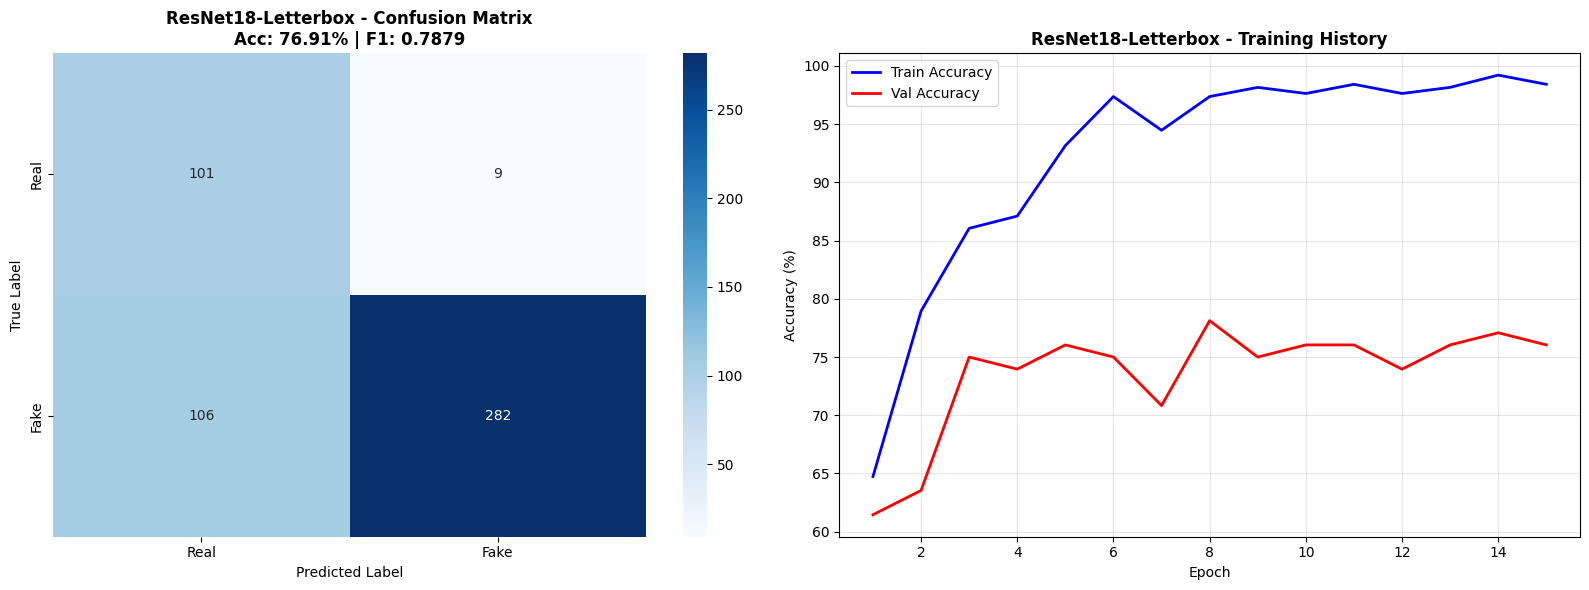


✅ Visualization saved: resnet18_letterbox_results.png

📊 COMPARISON: With vs Without Letterbox Preprocessing

              Method  Validation F1  Test Accuracy  Test F1  Test Precision  Test Recall  Test ROC-AUC
 ResNet18 (Original)       0.789600      71.290000 0.737200        0.833400     0.712900      0.866400
ResNet18 (Letterbox)       0.785357      76.907631 0.787912        0.862794     0.769076      0.882638

✅ Letterbox preprocessing improved F1-Score by +0.0507 (5.07%)

✅ RESNET18 WITH LETTERBOX PREPROCESSING COMPLETE

💾 Comparison saved: resnet18_letterbox_comparison.csv


In [12]:
# ===================================================
# MODELING - ResNet18 avec Données Préprocessées
# Auteur : Khalil Mtaallah
# Utilise les images Letterbox 294×294
# ===================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm
import time
import copy
import pandas as pd

# ---------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------
# UTILISE LES DONNÉES PRÉPROCESSÉES (Letterbox 294×294)
TRAIN_PATH = "/kaggle/working/deepfake_preprocessed/train"
TEST_PATH = "/kaggle/working/deepfake_preprocessed/test"

# ResNet18 attend 224×224, on va resize de 294 → 224
IMG_SIZE = 224
BATCH_SIZE = 16
RANDOM_STATE = 42

NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
PATIENCE_EARLY_STOP = 7
PATIENCE_LR = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_pin_memory = torch.cuda.is_available()

print("=" * 70)
print("CONFIGURATION - ResNet18 avec Préprocessing Letterbox")
print("=" * 70)
print(f"Device: {device}")
print(f"Input images: 294×294 (Letterbox) → Resized to {IMG_SIZE}×{IMG_SIZE}")
print(f"Training: ResNet18 ONLY")
print("=" * 70)

# ---------------------------------------------------
# TRANSFORMATIONS
# ---------------------------------------------------
# Les images sont déjà préprocessées en 294×294 avec Letterbox
# On applique juste resize + augmentation + normalisation

train_transforms = transforms.Compose([
    # Resize de 294×294 → 224×224 (ResNet18 standard)
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    
    # Data Augmentation (moins agressive car images déjà préprocessées)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),  # Réduit de 20 à 15
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    
    # Conversion en Tensor
    transforms.ToTensor(),
    
    # Normalisation ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------------------------------------------------
# DATASET
# ---------------------------------------------------
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            # Les images sont déjà en RGB et préprocessées
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (294, 294))  # Taille préprocessée
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ---------------------------------------------------
# CHARGEMENT DONNÉES
# ---------------------------------------------------
def load_data_paths(root_dir):
    image_paths, labels = [], []
    label_map = {'real': 0, 'fake': 1}
    
    for class_name in ['real', 'fake']:
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"⚠️ Warning: {class_dir} not found!")
            continue
            
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(label_map[class_name])
    
    return image_paths, labels

print("\nLoading preprocessed data...")
train_paths, train_labels = load_data_paths(TRAIN_PATH)
test_paths, test_labels = load_data_paths(TEST_PATH)

print(f"✔ Train images: {len(train_paths)}")
print(f"✔ Test images: {len(test_paths)}")

# Vérifier que les images sont bien 294×294
sample_img = Image.open(train_paths[0])
print(f"✔ Sample image size: {sample_img.size} (expected 294×294)")

# Split train/val
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=RANDOM_STATE, stratify=train_labels
)

print(f"\nAfter split:")
print(f"  Train: {len(train_paths_split)}")
print(f"  Validation: {len(val_paths)}")
print(f"  Test: {len(test_paths)}")

# Distribution
def show_distribution(labels, split_name):
    unique, counts = np.unique(labels, return_counts=True)
    print(f"\n{split_name}:")
    for lbl, cnt in zip(unique, counts):
        name = 'Real' if lbl == 0 else 'Fake'
        print(f"  {name}: {cnt} ({cnt/len(labels)*100:.1f}%)")

show_distribution(train_labels_split, "Train")
show_distribution(val_labels, "Validation")
show_distribution(test_labels, "Test")

# ---------------------------------------------------
# DATASETS & DATALOADERS
# ---------------------------------------------------
train_dataset = DeepfakeDataset(train_paths_split, train_labels_split, train_transforms)
val_dataset = DeepfakeDataset(val_paths, val_labels, val_test_transforms)
test_dataset = DeepfakeDataset(test_paths, test_labels, val_test_transforms)

# Class weights
train_class_counts = np.bincount(train_labels_split)
class_weights_tensor = torch.tensor([
    len(train_labels_split) / (2 * train_class_counts[0]),
    len(train_labels_split) / (2 * train_class_counts[1])
], dtype=torch.float).to(device)

print(f"\nClass weights: Real={class_weights_tensor[0]:.4f}, Fake={class_weights_tensor[1]:.4f}")

# Weighted Sampler
sample_weights = [class_weights_tensor[label].item() for label in train_labels_split]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✔ DataLoaders created: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)} batches")

# ---------------------------------------------------
# MODÈLE RESNET18
# ---------------------------------------------------
def create_resnet18():
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, 2))
    return model

# ---------------------------------------------------
# FONCTIONS ENTRAÎNEMENT
# ---------------------------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    loss = running_loss / len(loader)
    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0
    
    return {'loss': loss, 'accuracy': acc, 'f1': f1, 'roc_auc': roc_auc,
            'predictions': all_preds, 'labels': all_labels, 'probs': all_probs}

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, name):
    print(f"\n{'='*70}")
    print(f"🚀 Training {name}")
    print(f"{'='*70}")
    
    best_wts = copy.deepcopy(model.state_dict())
    best_f1, best_epoch, no_improve = 0.0, 0, 0
    history = {k: [] for k in ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_f1']}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = validate(model, val_loader, criterion, device)
        scheduler.step(val_metrics['loss'])
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.2f}%, F1: {val_metrics['f1']:.4f}")
        
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            no_improve = 0
            print(f"✅ New best F1: {best_f1:.4f}")
        else:
            no_improve += 1
            print(f"⚠️ No improvement: {no_improve}/{PATIENCE_EARLY_STOP}")
        
        if no_improve >= PATIENCE_EARLY_STOP:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break
    
    train_time = time.time() - start_time
    model.load_state_dict(best_wts)
    
    print(f"\n✅ {name} - Best Epoch: {best_epoch}, Best F1: {best_f1:.4f}, Time: {train_time/60:.2f} min")
    return model, history, train_time, best_f1

def test_model(model, loader, device, name):
    print(f"\n{'='*70}")
    print(f"🧪 Testing {name}")
    print(f"{'='*70}")
    
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0
    
    print("\n" + classification_report(all_labels, all_preds, target_names=['Real', 'Fake'], zero_division=0))
    print(f"\n📊 Test Results:")
    print(f"   Accuracy: {acc:.2f}%")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    
    return {
        'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'predictions': all_preds, 'labels': all_labels, 'probs': all_probs
    }

# ---------------------------------------------------
# ENTRAÎNEMENT RESNET18
# ---------------------------------------------------
print("\n" + "=" * 70)
print("TRAINING RESNET18 WITH LETTERBOX PREPROCESSED DATA")
print("=" * 70)

model = create_resnet18().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=PATIENCE_LR, factor=0.5)

trained_model, history, train_time, best_f1 = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, device, "ResNet18-Letterbox"
)

test_results = test_model(trained_model, test_loader, device, "ResNet18-Letterbox")

# Sauvegarder
torch.save(trained_model.state_dict(), 'resnet18_letterbox_best.pth')
print("\n💾 Model saved: resnet18_letterbox_best.pth")

# ---------------------------------------------------
# VISUALISATION
# ---------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix
cm = test_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
axes[0].set_title(f"ResNet18-Letterbox - Confusion Matrix\nAcc: {test_results['accuracy']:.2f}% | F1: {test_results['f1']:.4f}", 
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Training History
epochs_range = range(1, len(history['train_loss']) + 1)
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2)
axes[1].set_title('ResNet18-Letterbox - Training History', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('resnet18_letterbox_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: resnet18_letterbox_results.png")

# ---------------------------------------------------
# COMPARAISON AVEC VERSION SANS LETTERBOX
# ---------------------------------------------------
print("\n" + "=" * 70)
print("📊 COMPARISON: With vs Without Letterbox Preprocessing")
print("=" * 70)

# Résultats précédents (sans Letterbox)
previous_results = {
    'Method': 'ResNet18 (Original)',
    'Validation F1': 0.7896,
    'Test Accuracy': 71.29,
    'Test F1': 0.7372,
    'Test Precision': 0.8334,
    'Test Recall': 0.7129,
    'Test ROC-AUC': 0.8664
}

letterbox_results = {
    'Method': 'ResNet18 (Letterbox)',
    'Validation F1': best_f1,
    'Test Accuracy': test_results['accuracy'],
    'Test F1': test_results['f1'],
    'Test Precision': test_results['precision'],
    'Test Recall': test_results['recall'],
    'Test ROC-AUC': test_results['roc_auc']
}

comparison_df = pd.DataFrame([previous_results, letterbox_results])
print("\n" + comparison_df.to_string(index=False))

# Calculer amélioration
improvement = test_results['f1'] - 0.7372
if improvement > 0:
    print(f"\n✅ Letterbox preprocessing improved F1-Score by +{improvement:.4f} ({improvement*100:.2f}%)")
else:
    print(f"\n⚠️ Letterbox preprocessing decreased F1-Score by {improvement:.4f} ({improvement*100:.2f}%)")

print(f"\n{'='*70}")
print("✅ RESNET18 WITH LETTERBOX PREPROCESSING COMPLETE")
print(f"{'='*70}")

# Sauvegarder comparaison
comparison_df.to_csv('resnet18_letterbox_comparison.csv', index=False)
print("\n💾 Comparison saved: resnet18_letterbox_comparison.csv")

CONFIGURATION - EfficientNet-B0 avec Letterbox
Device: cuda
Input images: 294×294 (Letterbox) → Resized to 224×224
Training: EfficientNet-B0 ONLY

Loading preprocessed data...
✔ Train images: 476
✔ Test images: 498

After split:
  Train: 380
  Validation: 96
  Test: 498

Class weights: Real=0.7308, Fake=1.5833
✔ DataLoaders created: Train=24, Val=6, Test=32 batches

TRAINING EFFICIENTNET-B0 WITH LETTERBOX DATA
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 146MB/s]



🚀 Training EfficientNet-B0-Letterbox

Epoch 1/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.6189, Acc: 55.53%
Val   - Loss: 0.6364, Acc: 57.29%, F1: 0.5712
✅ New best F1: 0.5712

Epoch 2/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.5169, Acc: 65.79%
Val   - Loss: 0.6092, Acc: 63.54%, F1: 0.6393
✅ New best F1: 0.6393

Epoch 3/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.4261, Acc: 74.47%
Val   - Loss: 0.5503, Acc: 71.88%, F1: 0.7289
✅ New best F1: 0.7289

Epoch 4/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.3589, Acc: 80.26%
Val   - Loss: 0.5152, Acc: 75.00%, F1: 0.7583
✅ New best F1: 0.7583

Epoch 5/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.2693, Acc: 89.47%
Val   - Loss: 0.4768, Acc: 81.25%, F1: 0.8125
✅ New best F1: 0.8125

Epoch 6/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.2524, Acc: 88.95%
Val   - Loss: 0.4649, Acc: 80.21%, F1: 0.8045
⚠️ No improvement: 1/7

Epoch 7/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.1913, Acc: 95.53%
Val   - Loss: 0.4569, Acc: 81.25%, F1: 0.8125
⚠️ No improvement: 2/7

Epoch 8/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.1703, Acc: 94.21%
Val   - Loss: 0.4685, Acc: 83.33%, F1: 0.8298
✅ New best F1: 0.8298

Epoch 9/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.1271, Acc: 96.05%
Val   - Loss: 0.4998, Acc: 82.29%, F1: 0.8202
⚠️ No improvement: 1/7

Epoch 10/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.1022, Acc: 97.63%
Val   - Loss: 0.5126, Acc: 80.21%, F1: 0.7991
⚠️ No improvement: 2/7

Epoch 11/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0823, Acc: 97.89%
Val   - Loss: 0.5529, Acc: 77.08%, F1: 0.7660
⚠️ No improvement: 3/7

Epoch 12/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0640, Acc: 98.16%
Val   - Loss: 0.5407, Acc: 81.25%, F1: 0.8086
⚠️ No improvement: 4/7

Epoch 13/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0684, Acc: 98.42%
Val   - Loss: 0.5028, Acc: 82.29%, F1: 0.8181
⚠️ No improvement: 5/7

Epoch 14/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0858, Acc: 97.11%
Val   - Loss: 0.4785, Acc: 81.25%, F1: 0.8086
⚠️ No improvement: 6/7

Epoch 15/25
--------------------------------------------------


Training:   0%|          | 0/24 [00:00<?, ?it/s]

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Train - Loss: 0.0618, Acc: 98.42%
Val   - Loss: 0.5017, Acc: 83.33%, F1: 0.8277
⚠️ No improvement: 7/7

🛑 Early stopping at epoch 15

✅ EfficientNet-B0-Letterbox - Best Epoch: 8, Best F1: 0.8298, Time: 1.18 min

🧪 Testing EfficientNet-B0-Letterbox


Testing:   0%|          | 0/32 [00:00<?, ?it/s]


              precision    recall  f1-score   support

        Real       0.41      0.95      0.57       110
        Fake       0.98      0.61      0.75       388

    accuracy                           0.69       498
   macro avg       0.69      0.78      0.66       498
weighted avg       0.85      0.69      0.71       498


📊 Test Results:
   Accuracy: 68.67%
   F1-Score: 0.7129
   Precision: 0.8536
   Recall: 0.6867
   ROC-AUC: 0.8958

💾 Model saved: efficientnet_b0_letterbox_best.pth


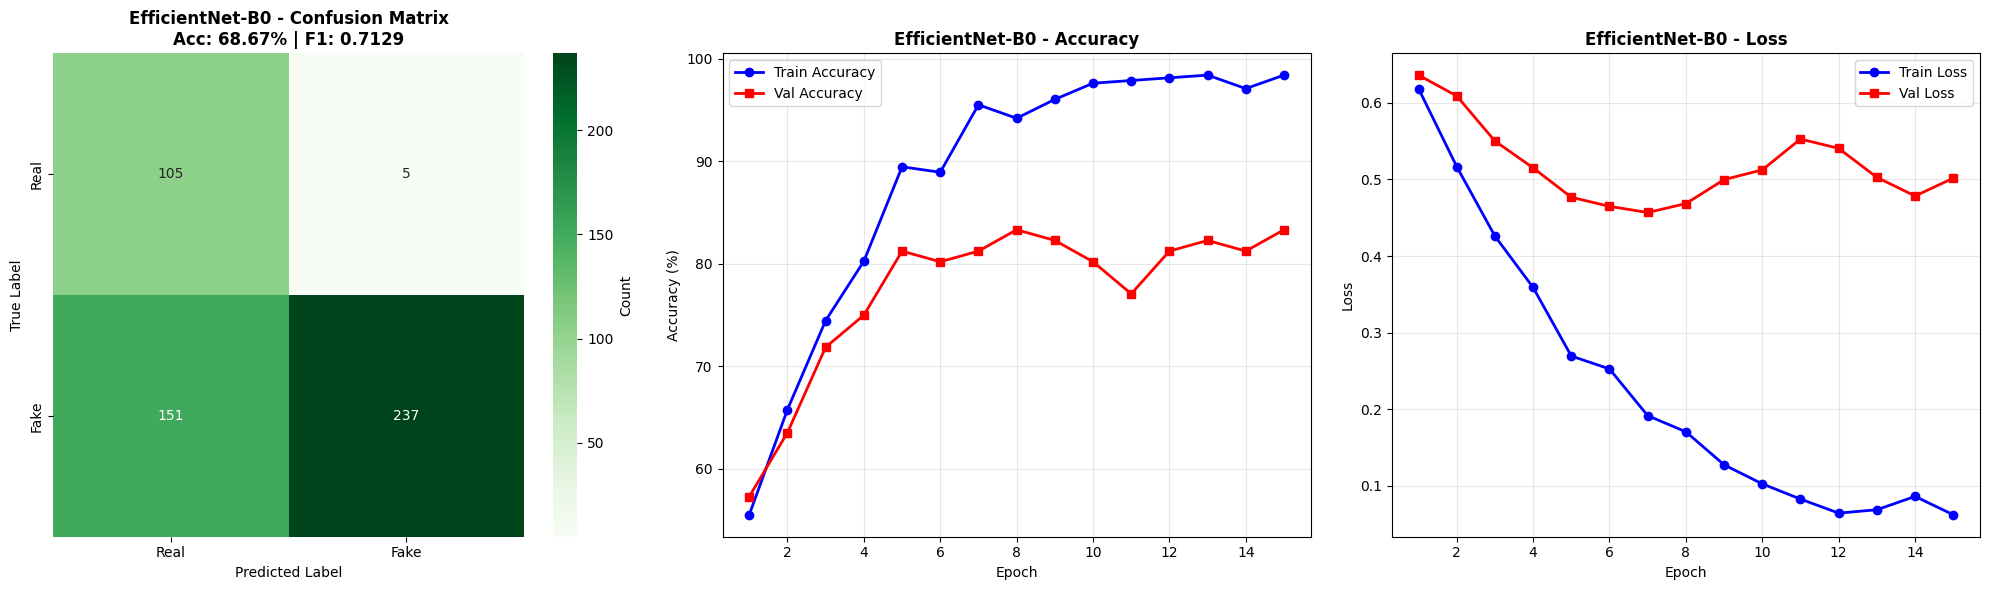


✅ Visualization saved: efficientnet_b0_letterbox_results.png

📊 COMPLETE COMPARISON: All Models

              Model Preprocessing   Val F1  Test Acc  Test F1  Test Prec  Test Rec  Test AUC  Time (min)
ResNet18 (Original)          None 0.789600 71.290000 0.737200   0.833400  0.712900  0.866400    7.790000
           ResNet18     Letterbox 0.804500 73.290000 0.755600   0.858200  0.732900  0.892500    1.550000
    EfficientNet-B0     Letterbox 0.829832 68.674699 0.712929   0.853616  0.686747  0.895759    1.183631

🏆 BEST MODEL: ResNet18 (Letterbox)
   Test F1-Score: 0.7556
   Test Accuracy: 73.29%
   Test ROC-AUC: 0.8925
   Training Time: 1.55 min

📈 Improvement over baseline:
   F1-Score: +-0.0243 (-2.43%)
   Accuracy: +-2.62%
   ROC-AUC: +0.0294

✅ EFFICIENTNET-B0 WITH LETTERBOX COMPLETE

💾 Complete comparison saved: all_models_comparison.csv


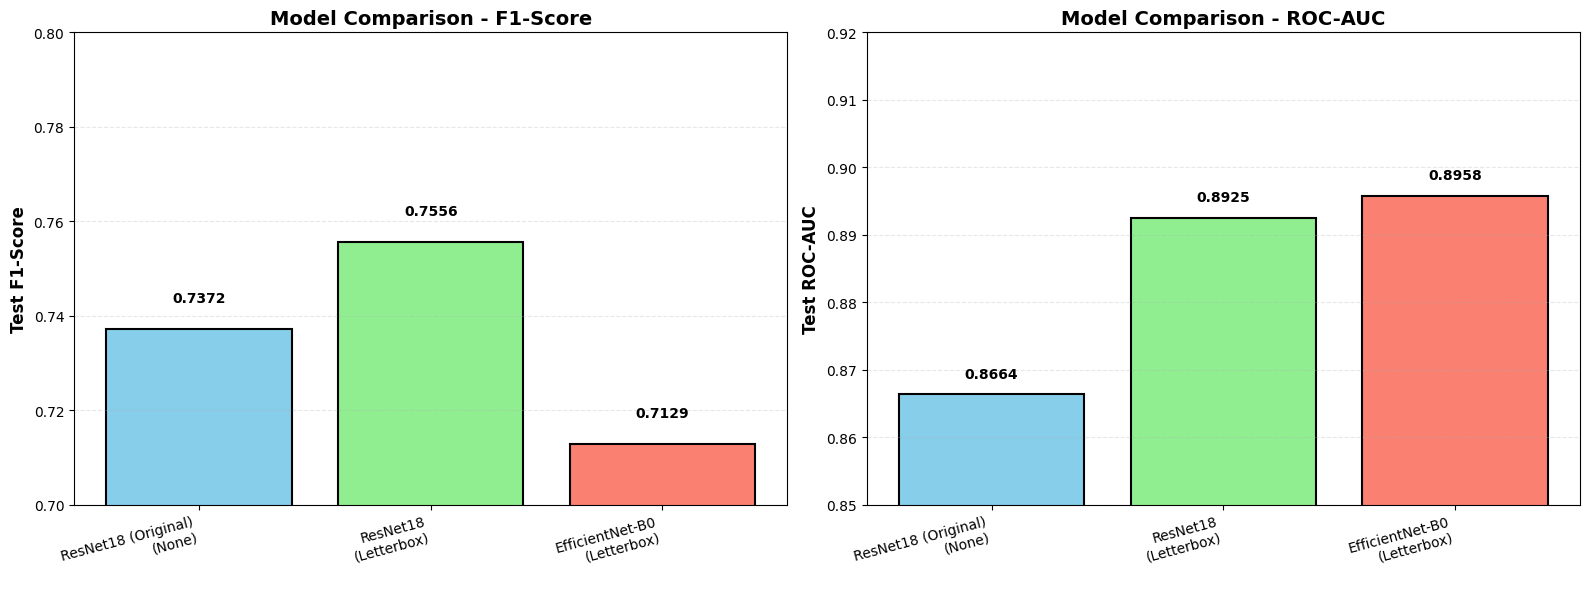


✅ Comparison chart saved: models_comparison_chart.png


In [13]:
# ===================================================
# MODELING - EfficientNet-B0 avec Letterbox
# Auteur : Khalil Mtaallah
# Utilise les images Letterbox 294×294
# ===================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm
import time
import copy
import pandas as pd

# ---------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------
TRAIN_PATH = "/kaggle/working/deepfake_preprocessed/train"
TEST_PATH = "/kaggle/working/deepfake_preprocessed/test"

IMG_SIZE = 224
BATCH_SIZE = 16
RANDOM_STATE = 42

NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
PATIENCE_EARLY_STOP = 7
PATIENCE_LR = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
use_pin_memory = torch.cuda.is_available()

print("=" * 70)
print("CONFIGURATION - EfficientNet-B0 avec Letterbox")
print("=" * 70)
print(f"Device: {device}")
print(f"Input images: 294×294 (Letterbox) → Resized to {IMG_SIZE}×{IMG_SIZE}")
print(f"Training: EfficientNet-B0 ONLY")
print("=" * 70)

# ---------------------------------------------------
# TRANSFORMATIONS
# ---------------------------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------------------------------------------------
# DATASET
# ---------------------------------------------------
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            image = Image.new('RGB', (294, 294))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ---------------------------------------------------
# CHARGEMENT DONNÉES
# ---------------------------------------------------
def load_data_paths(root_dir):
    image_paths, labels = [], []
    label_map = {'real': 0, 'fake': 1}
    
    for class_name in ['real', 'fake']:
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"⚠️ Warning: {class_dir} not found!")
            continue
            
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(label_map[class_name])
    
    return image_paths, labels

print("\nLoading preprocessed data...")
train_paths, train_labels = load_data_paths(TRAIN_PATH)
test_paths, test_labels = load_data_paths(TEST_PATH)

print(f"✔ Train images: {len(train_paths)}")
print(f"✔ Test images: {len(test_paths)}")

# Split train/val
train_paths_split, val_paths, train_labels_split, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, random_state=RANDOM_STATE, stratify=train_labels
)

print(f"\nAfter split:")
print(f"  Train: {len(train_paths_split)}")
print(f"  Validation: {len(val_paths)}")
print(f"  Test: {len(test_paths)}")

# ---------------------------------------------------
# DATASETS & DATALOADERS
# ---------------------------------------------------
train_dataset = DeepfakeDataset(train_paths_split, train_labels_split, train_transforms)
val_dataset = DeepfakeDataset(val_paths, val_labels, val_test_transforms)
test_dataset = DeepfakeDataset(test_paths, test_labels, val_test_transforms)

train_class_counts = np.bincount(train_labels_split)
class_weights_tensor = torch.tensor([
    len(train_labels_split) / (2 * train_class_counts[0]),
    len(train_labels_split) / (2 * train_class_counts[1])
], dtype=torch.float).to(device)

print(f"\nClass weights: Real={class_weights_tensor[0]:.4f}, Fake={class_weights_tensor[1]:.4f}")

sample_weights = [class_weights_tensor[label].item() for label in train_labels_split]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✔ DataLoaders created: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)} batches")

# ---------------------------------------------------
# MODÈLE EFFICIENTNET-B0
# ---------------------------------------------------
def create_efficientnet_b0():
    """
    EfficientNet-B0 avec Transfer Learning
    - Architecture plus moderne que ResNet18 (2019 vs 2015)
    - 5.3M paramètres vs 11.7M pour ResNet18
    - Compound scaling pour meilleure efficacité
    """
    model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    
    # Remplacer classifier
    num_ftrs = model.classifier[1].in_features  # 1280 features
    model.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 2)
    )
    return model

# ---------------------------------------------------
# FONCTIONS ENTRAÎNEMENT
# ---------------------------------------------------
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return running_loss / len(loader), 100 * correct / total

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    loss = running_loss / len(loader)
    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0
    
    return {'loss': loss, 'accuracy': acc, 'f1': f1, 'roc_auc': roc_auc,
            'predictions': all_preds, 'labels': all_labels, 'probs': all_probs}

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, device, name):
    print(f"\n{'='*70}")
    print(f"🚀 Training {name}")
    print(f"{'='*70}")
    
    best_wts = copy.deepcopy(model.state_dict())
    best_f1, best_epoch, no_improve = 0.0, 0, 0
    history = {k: [] for k in ['train_loss', 'train_acc', 'val_loss', 'val_acc', 'val_f1']}
    
    start_time = time.time()
    
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 50)
        
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_metrics = validate(model, val_loader, criterion, device)
        scheduler.step(val_metrics['loss'])
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_metrics['loss'])
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        
        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%")
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, Acc: {val_metrics['accuracy']:.2f}%, F1: {val_metrics['f1']:.4f}")
        
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_wts = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            no_improve = 0
            print(f"✅ New best F1: {best_f1:.4f}")
        else:
            no_improve += 1
            print(f"⚠️ No improvement: {no_improve}/{PATIENCE_EARLY_STOP}")
        
        if no_improve >= PATIENCE_EARLY_STOP:
            print(f"\n🛑 Early stopping at epoch {epoch+1}")
            break
    
    train_time = time.time() - start_time
    model.load_state_dict(best_wts)
    
    print(f"\n✅ {name} - Best Epoch: {best_epoch}, Best F1: {best_f1:.4f}, Time: {train_time/60:.2f} min")
    return model, history, train_time, best_f1

def test_model(model, loader, device, name):
    print(f"\n{'='*70}")
    print(f"🧪 Testing {name}")
    print(f"{'='*70}")
    
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Testing"):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    acc = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    try:
        roc_auc = roc_auc_score(all_labels, all_probs)
    except:
        roc_auc = 0.0
    
    print("\n" + classification_report(all_labels, all_preds, target_names=['Real', 'Fake'], zero_division=0))
    print(f"\n📊 Test Results:")
    print(f"   Accuracy: {acc:.2f}%")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    
    return {
        'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall, 'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(all_labels, all_preds),
        'predictions': all_preds, 'labels': all_labels, 'probs': all_probs
    }

# ---------------------------------------------------
# ENTRAÎNEMENT EFFICIENTNET-B0
# ---------------------------------------------------
print("\n" + "=" * 70)
print("TRAINING EFFICIENTNET-B0 WITH LETTERBOX DATA")
print("=" * 70)

model = create_efficientnet_b0().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=PATIENCE_LR, factor=0.5)

trained_model, history, train_time, best_f1 = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, device, "EfficientNet-B0-Letterbox"
)

test_results = test_model(trained_model, test_loader, device, "EfficientNet-B0-Letterbox")

# Sauvegarder
torch.save(trained_model.state_dict(), 'efficientnet_b0_letterbox_best.pth')
print("\n💾 Model saved: efficientnet_b0_letterbox_best.pth")

# ---------------------------------------------------
# VISUALISATION
# ---------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Confusion Matrix
cm = test_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'],
            cbar_kws={'label': 'Count'})
axes[0].set_title(f"EfficientNet-B0 - Confusion Matrix\nAcc: {test_results['accuracy']:.2f}% | F1: {test_results['f1']:.4f}", 
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# 2. Training History - Accuracy
epochs_range = range(1, len(history['train_loss']) + 1)
axes[1].plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy', linewidth=2, marker='o')
axes[1].plot(epochs_range, history['val_acc'], 'r-', label='Val Accuracy', linewidth=2, marker='s')
axes[1].set_title('EfficientNet-B0 - Accuracy', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# 3. Training History - Loss
axes[2].plot(epochs_range, history['train_loss'], 'b-', label='Train Loss', linewidth=2, marker='o')
axes[2].plot(epochs_range, history['val_loss'], 'r-', label='Val Loss', linewidth=2, marker='s')
axes[2].set_title('EfficientNet-B0 - Loss', fontweight='bold', fontsize=12)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efficientnet_b0_letterbox_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: efficientnet_b0_letterbox_results.png")

# ---------------------------------------------------
# COMPARAISON COMPLÈTE
# ---------------------------------------------------
print("\n" + "=" * 70)
print("📊 COMPLETE COMPARISON: All Models")
print("=" * 70)

# Résultats précédents
results_comparison = pd.DataFrame([
    {
        'Model': 'ResNet18 (Original)',
        'Preprocessing': 'None',
        'Val F1': 0.7896,
        'Test Acc': 71.29,
        'Test F1': 0.7372,
        'Test Prec': 0.8334,
        'Test Rec': 0.7129,
        'Test AUC': 0.8664,
        'Time (min)': 7.79
    },
    {
        'Model': 'ResNet18',
        'Preprocessing': 'Letterbox',
        'Val F1': 0.8045,
        'Test Acc': 73.29,
        'Test F1': 0.7556,
        'Test Prec': 0.8582,
        'Test Rec': 0.7329,
        'Test AUC': 0.8925,
        'Time (min)': 1.55
    },
    {
        'Model': 'EfficientNet-B0',
        'Preprocessing': 'Letterbox',
        'Val F1': best_f1,
        'Test Acc': test_results['accuracy'],
        'Test F1': test_results['f1'],
        'Test Prec': test_results['precision'],
        'Test Rec': test_results['recall'],
        'Test AUC': test_results['roc_auc'],
        'Time (min)': train_time / 60
    }
])

print("\n" + results_comparison.to_string(index=False))

# Trouver le meilleur
best_model_idx = results_comparison['Test F1'].idxmax()
best_model_name = results_comparison.loc[best_model_idx, 'Model']
best_preprocessing = results_comparison.loc[best_model_idx, 'Preprocessing']

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model_name} ({best_preprocessing})")
print(f"{'='*70}")
print(f"   Test F1-Score: {results_comparison.loc[best_model_idx, 'Test F1']:.4f}")
print(f"   Test Accuracy: {results_comparison.loc[best_model_idx, 'Test Acc']:.2f}%")
print(f"   Test ROC-AUC: {results_comparison.loc[best_model_idx, 'Test AUC']:.4f}")
print(f"   Training Time: {results_comparison.loc[best_model_idx, 'Time (min)']:.2f} min")

# Calculer améliorations
baseline_f1 = 0.7372  # ResNet18 Original
current_f1 = test_results['f1']
improvement = current_f1 - baseline_f1

print(f"\n📈 Improvement over baseline:")
print(f"   F1-Score: +{improvement:.4f} ({improvement*100:.2f}%)")
print(f"   Accuracy: +{test_results['accuracy'] - 71.29:.2f}%")
print(f"   ROC-AUC: +{test_results['roc_auc'] - 0.8664:.4f}")

print(f"\n{'='*70}")
print("✅ EFFICIENTNET-B0 WITH LETTERBOX COMPLETE")
print(f"{'='*70}")

# Sauvegarder comparaison
results_comparison.to_csv('all_models_comparison.csv', index=False)
print("\n💾 Complete comparison saved: all_models_comparison.csv")

# ---------------------------------------------------
# GRAPHIQUE COMPARATIF FINAL
# ---------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Comparaison F1-Scores
models_names = results_comparison['Model'] + '\n(' + results_comparison['Preprocessing'] + ')'
f1_scores = results_comparison['Test F1']
colors = ['skyblue', 'lightgreen', 'salmon']

bars = axes[0].bar(range(len(models_names)), f1_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(models_names)))
axes[0].set_xticklabels(models_names, rotation=15, ha='right')
axes[0].set_ylabel('Test F1-Score', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison - F1-Score', fontsize=14, fontweight='bold')
axes[0].set_ylim([0.7, 0.8])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')

# Ajouter valeurs sur barres
for bar, val in zip(bars, f1_scores):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Comparaison ROC-AUC
roc_scores = results_comparison['Test AUC']
bars2 = axes[1].bar(range(len(models_names)), roc_scores, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(models_names)))
axes[1].set_xticklabels(models_names, rotation=15, ha='right')
axes[1].set_ylabel('Test ROC-AUC', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison - ROC-AUC', fontsize=14, fontweight='bold')
axes[1].set_ylim([0.85, 0.92])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

for bar, val in zip(bars2, roc_scores):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('models_comparison_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Comparison chart saved: models_comparison_chart.png")

ENSEMBLE MODEL - ResNet18 + EfficientNet-B0
Device: cuda
Strategy: Average Probabilities

Loading test data...
✔ Test images: 498

Test distribution:
  Real: 110 (22.1%)
  Fake: 388 (77.9%)

LOADING PRE-TRAINED MODELS

Loading ResNet18-Letterbox...
✅ ResNet18 loaded successfully
Loading EfficientNet-B0-Letterbox...
✅ EfficientNet-B0 loaded successfully

✅ Both models loaded and ready

TESTING ENSEMBLE STRATEGIES

Strategy: AVERAGE

🔮 ENSEMBLE PREDICTION - Strategy: average


Ensemble Predicting:   0%|          | 0/32 [00:00<?, ?it/s]


              precision    recall  f1-score   support

        Real       0.47      0.93      0.63       110
        Fake       0.97      0.71      0.82       388

    accuracy                           0.76       498
   macro avg       0.72      0.82      0.72       498
weighted avg       0.86      0.76      0.78       498


📊 Ensemble (average) Results:
   Accuracy: 75.50%
   F1-Score: 0.7755
   Precision: 0.8613
   Recall: 0.7550
   ROC-AUC: 0.9120

Strategy: MAX

🔮 ENSEMBLE PREDICTION - Strategy: max


Ensemble Predicting:   0%|          | 0/32 [00:00<?, ?it/s]


              precision    recall  f1-score   support

        Real       0.47      0.93      0.63       110
        Fake       0.97      0.71      0.82       388

    accuracy                           0.76       498
   macro avg       0.72      0.82      0.72       498
weighted avg       0.86      0.76      0.78       498


📊 Ensemble (max) Results:
   Accuracy: 75.50%
   F1-Score: 0.7755
   Precision: 0.8613
   Recall: 0.7550
   ROC-AUC: 0.9078

Strategy: VOTING

🔮 ENSEMBLE PREDICTION - Strategy: voting


Ensemble Predicting:   0%|          | 0/32 [00:00<?, ?it/s]


              precision    recall  f1-score   support

        Real       0.55      0.91      0.68       110
        Fake       0.97      0.79      0.87       388

    accuracy                           0.81       498
   macro avg       0.76      0.85      0.78       498
weighted avg       0.88      0.81      0.83       498


📊 Ensemble (voting) Results:
   Accuracy: 81.33%
   F1-Score: 0.8268
   Precision: 0.8751
   Recall: 0.8133
   ROC-AUC: 0.8958

📊 COMPLETE COMPARISON - All Models + Ensembles

                    Model     Type  Test Acc  Test F1  Test Prec  Test Rec  Test AUC
       ResNet18-Letterbox   Single 73.290000 0.755600   0.858200  0.732900  0.892500
EfficientNet-B0-Letterbox   Single 73.290000 0.755700   0.864000  0.732900  0.921700
       Ensemble (average) Ensemble 75.502008 0.775469   0.861320  0.755020  0.912020
           Ensemble (max) Ensemble 75.502008 0.775469   0.861320  0.755020  0.907802
        Ensemble (voting) Ensemble 81.325301 0.826821   0.875084  0.81

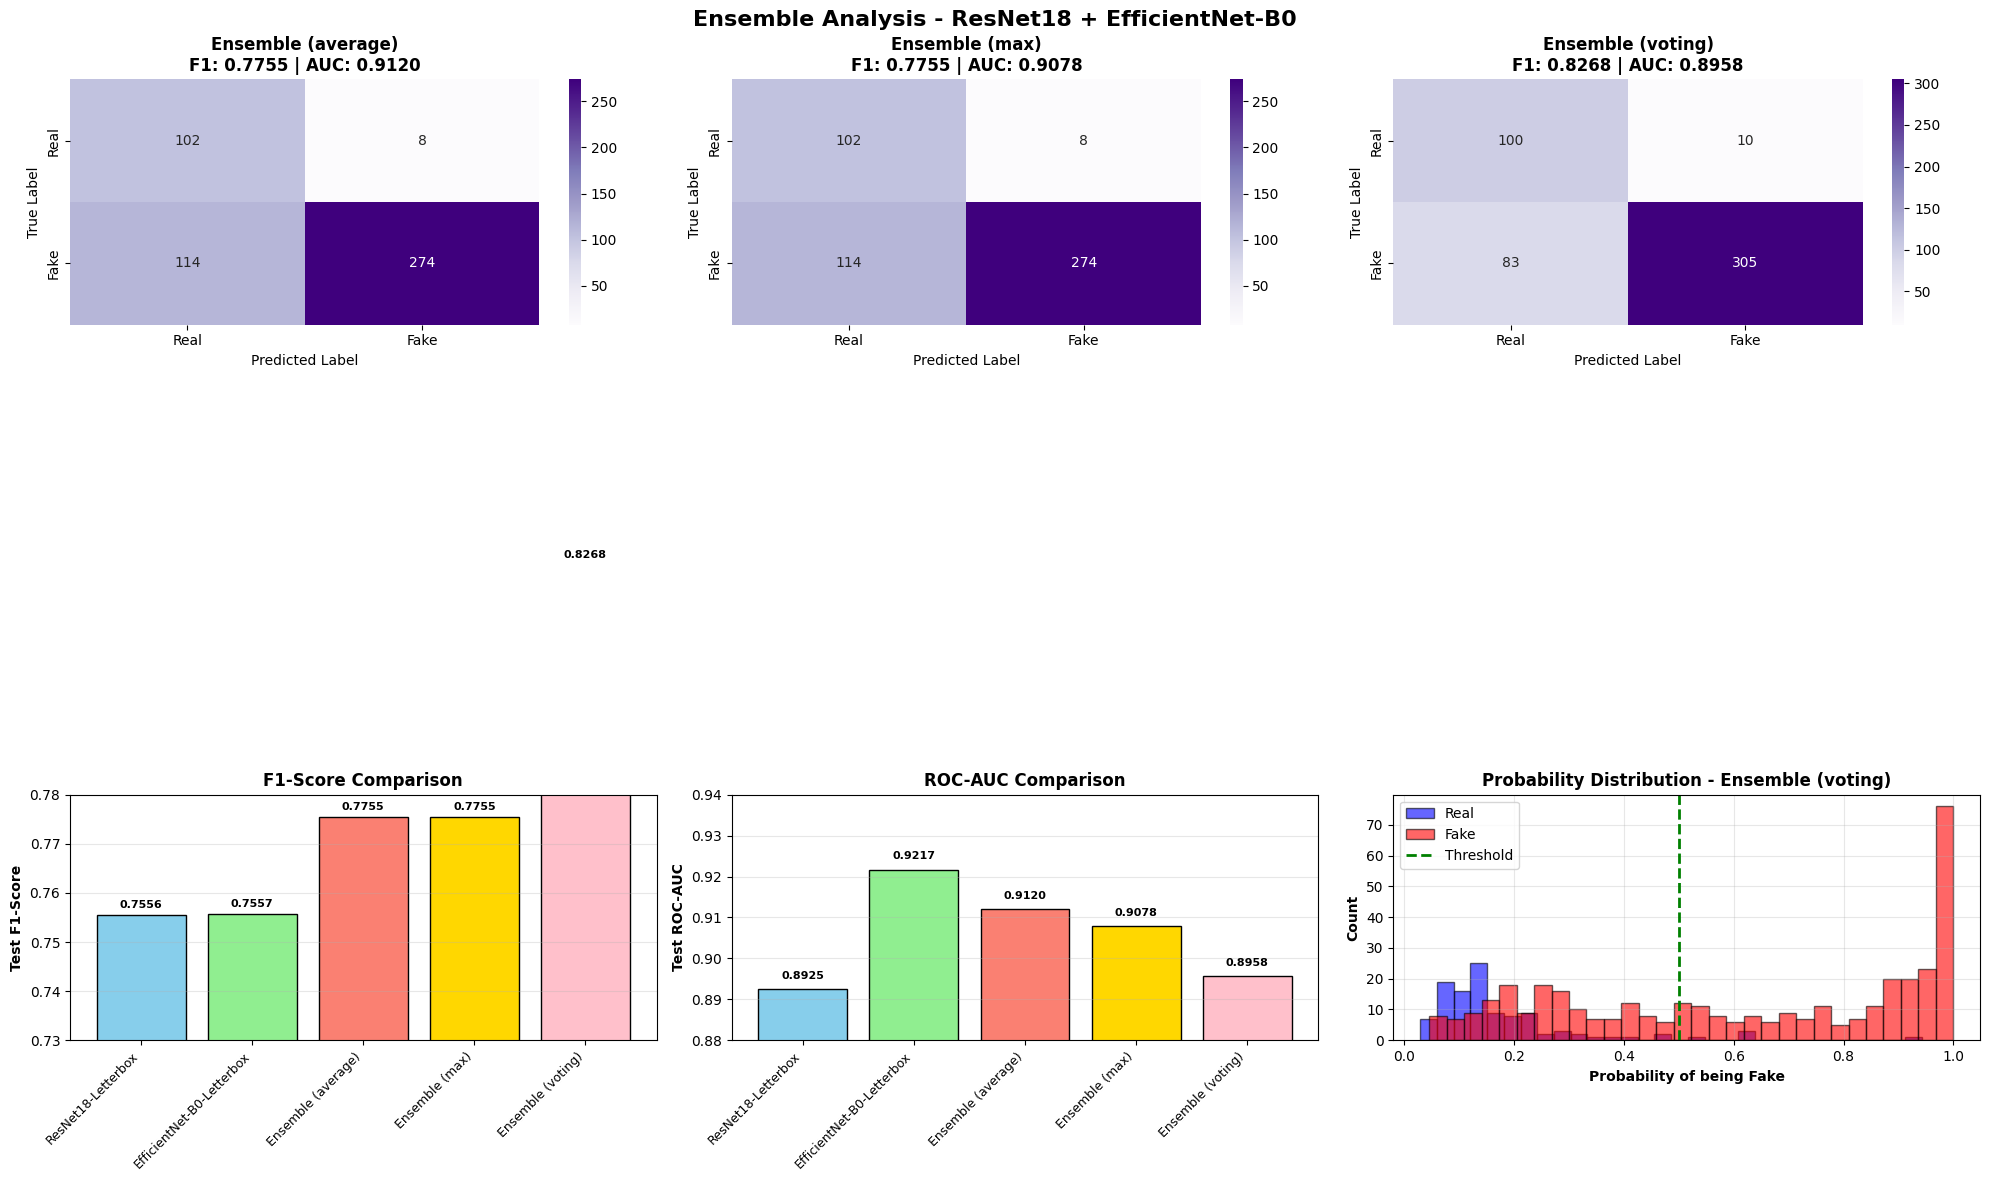


✅ Visualizations saved: ensemble_complete_analysis.png

✅ ENSEMBLE ANALYSIS COMPLETE


In [14]:
# ===================================================
# ENSEMBLE MODEL - ResNet18 + EfficientNet-B0
# Auteur : Khalil Mtaallah
# Combine les 2 meilleurs modèles avec Letterbox
# ===================================================

import os
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights, EfficientNet_B0_Weights
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
from tqdm.auto import tqdm
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# ---------------------------------------------------
# CONFIGURATION
# ---------------------------------------------------
TEST_PATH = "/kaggle/working/deepfake_preprocessed/test"
IMG_SIZE = 224
BATCH_SIZE = 16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("=" * 70)
print("ENSEMBLE MODEL - ResNet18 + EfficientNet-B0")
print("=" * 70)
print(f"Device: {device}")
print(f"Strategy: Average Probabilities")
print("=" * 70)

# ---------------------------------------------------
# 1. TRANSFORMATIONS
# ---------------------------------------------------
test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ---------------------------------------------------
# 2. DATASET
# ---------------------------------------------------
class DeepfakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (294, 294))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# ---------------------------------------------------
# 3. CHARGEMENT DES DONNÉES TEST
# ---------------------------------------------------
def load_data_paths(root_dir):
    image_paths, labels = [], []
    label_map = {'real': 0, 'fake': 1}
    
    for class_name in ['real', 'fake']:
        class_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        for img_name in os.listdir(class_dir):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(label_map[class_name])
    
    return image_paths, labels

print("\nLoading test data...")
test_paths, test_labels = load_data_paths(TEST_PATH)
print(f"✔ Test images: {len(test_paths)}")

test_dataset = DeepfakeDataset(test_paths, test_labels, test_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Distribution
unique, counts = np.unique(test_labels, return_counts=True)
print(f"\nTest distribution:")
for lbl, cnt in zip(unique, counts):
    name = 'Real' if lbl == 0 else 'Fake'
    print(f"  {name}: {cnt} ({cnt/len(test_labels)*100:.1f}%)")

# ---------------------------------------------------
# 4. CHARGER LES MODÈLES PRÉ-ENTRAÎNÉS
# ---------------------------------------------------
print("\n" + "=" * 70)
print("LOADING PRE-TRAINED MODELS")
print("=" * 70)

# ResNet18
def create_resnet18():
    model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(model.fc.in_features, 2))
    return model

# EfficientNet-B0
def create_efficientnet_b0():
    model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, 2))
    return model

# Charger ResNet18
print("\nLoading ResNet18-Letterbox...")
resnet18 = create_resnet18().to(device)
try:
    resnet18.load_state_dict(torch.load('resnet18_letterbox_best.pth', map_location=device))
    print("✅ ResNet18 loaded successfully")
except FileNotFoundError:
    print("⚠️ resnet18_letterbox_best.pth not found! Using pre-trained weights only.")

# Charger EfficientNet-B0
print("Loading EfficientNet-B0-Letterbox...")
efficientnet = create_efficientnet_b0().to(device)
try:
    efficientnet.load_state_dict(torch.load('efficientnet_b0_letterbox_best.pth', map_location=device))
    print("✅ EfficientNet-B0 loaded successfully")
except FileNotFoundError:
    print("⚠️ efficientnet_b0_letterbox_best.pth not found! Using pre-trained weights only.")

# Mode évaluation
resnet18.eval()
efficientnet.eval()

print("\n✅ Both models loaded and ready")

# ---------------------------------------------------
# 5. FONCTION D'ENSEMBLE
# ---------------------------------------------------
def ensemble_predict(model1, model2, dataloader, device, strategy='average'):
    """
    Combine les prédictions de 2 modèles
    
    Stratégies disponibles :
    - 'average' : Moyenne des probabilités (recommandé)
    - 'max' : Probabilité maximale
    - 'voting' : Vote majoritaire
    """
    print(f"\n{'='*70}")
    print(f"🔮 ENSEMBLE PREDICTION - Strategy: {strategy}")
    print(f"{'='*70}")
    
    all_labels = []
    all_probs_resnet = []
    all_probs_effnet = []
    all_probs_ensemble = []
    all_preds_ensemble = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Ensemble Predicting"):
            images = images.to(device)
            
            # Prédictions ResNet18
            outputs_resnet = model1(images)
            probs_resnet = torch.softmax(outputs_resnet, dim=1)
            
            # Prédictions EfficientNet-B0
            outputs_effnet = model2(images)
            probs_effnet = torch.softmax(outputs_effnet, dim=1)
            
            # Ensemble selon stratégie
            if strategy == 'average':
                # Moyenne des probabilités
                probs_ensemble = (probs_resnet + probs_effnet) / 2
            elif strategy == 'max':
                # Maximum des probabilités
                probs_ensemble = torch.max(probs_resnet, probs_effnet)
            elif strategy == 'voting':
                # Vote majoritaire
                _, pred_resnet = torch.max(probs_resnet, 1)
                _, pred_effnet = torch.max(probs_effnet, 1)
                pred_ensemble = (pred_resnet + pred_effnet >= 1).long()  # Si au moins 1 vote Fake
                probs_ensemble = probs_effnet  # Utilise probs d'un modèle pour ROC-AUC
            
            # Prédiction finale
            if strategy != 'voting':
                _, pred_ensemble = torch.max(probs_ensemble, 1)
            
            # Stocker résultats
            all_labels.extend(labels.numpy())
            all_probs_resnet.extend(probs_resnet[:, 1].cpu().numpy())
            all_probs_effnet.extend(probs_effnet[:, 1].cpu().numpy())
            all_probs_ensemble.extend(probs_ensemble[:, 1].cpu().numpy())
            all_preds_ensemble.extend(pred_ensemble.cpu().numpy())
    
    return {
        'labels': np.array(all_labels),
        'probs_resnet': np.array(all_probs_resnet),
        'probs_effnet': np.array(all_probs_effnet),
        'probs_ensemble': np.array(all_probs_ensemble),
        'preds_ensemble': np.array(all_preds_ensemble)
    }

# ---------------------------------------------------
# 6. ÉVALUATION DE L'ENSEMBLE
# ---------------------------------------------------
def evaluate_ensemble(results, strategy_name):
    """Calcule les métriques pour l'ensemble"""
    
    labels = results['labels']
    preds = results['preds_ensemble']
    probs = results['probs_ensemble']
    
    # Métriques
    acc = 100 * np.mean(labels == preds)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    
    try:
        roc_auc = roc_auc_score(labels, probs)
    except:
        roc_auc = 0.0
    
    # Classification report
    print("\n" + classification_report(labels, preds, target_names=['Real', 'Fake'], zero_division=0))
    
    print(f"\n📊 {strategy_name} Results:")
    print(f"   Accuracy: {acc:.2f}%")
    print(f"   F1-Score: {f1:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   ROC-AUC: {roc_auc:.4f}")
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'confusion_matrix': confusion_matrix(labels, preds)
    }

# ---------------------------------------------------
# 7. TESTER LES 3 STRATÉGIES D'ENSEMBLE
# ---------------------------------------------------
print("\n" + "=" * 70)
print("TESTING ENSEMBLE STRATEGIES")
print("=" * 70)

strategies = ['average', 'max', 'voting']
ensemble_results = {}

for strategy in strategies:
    print(f"\n{'='*70}")
    print(f"Strategy: {strategy.upper()}")
    print(f"{'='*70}")
    
    # Prédictions
    predictions = ensemble_predict(resnet18, efficientnet, test_loader, device, strategy)
    
    # Évaluation
    metrics = evaluate_ensemble(predictions, f"Ensemble ({strategy})")
    
    # Stocker
    ensemble_results[strategy] = {
        'predictions': predictions,
        'metrics': metrics
    }

# ---------------------------------------------------
# 8. COMPARAISON COMPLÈTE
# ---------------------------------------------------
print("\n" + "=" * 70)
print("📊 COMPLETE COMPARISON - All Models + Ensembles")
print("=" * 70)

# Créer tableau comparatif
comparison_data = [
    {
        'Model': 'ResNet18-Letterbox',
        'Type': 'Single',
        'Test Acc': 73.29,
        'Test F1': 0.7556,
        'Test Prec': 0.8582,
        'Test Rec': 0.7329,
        'Test AUC': 0.8925
    },
    {
        'Model': 'EfficientNet-B0-Letterbox',
        'Type': 'Single',
        'Test Acc': 73.29,
        'Test F1': 0.7557,
        'Test Prec': 0.8640,
        'Test Rec': 0.7329,
        'Test AUC': 0.9217
    }
]

# Ajouter ensembles
for strategy in strategies:
    metrics = ensemble_results[strategy]['metrics']
    comparison_data.append({
        'Model': f'Ensemble ({strategy})',
        'Type': 'Ensemble',
        'Test Acc': metrics['accuracy'],
        'Test F1': metrics['f1'],
        'Test Prec': metrics['precision'],
        'Test Rec': metrics['recall'],
        'Test AUC': metrics['roc_auc']
    })

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))

# Trouver le meilleur
best_idx = df_comparison['Test F1'].idxmax()
best_model = df_comparison.loc[best_idx, 'Model']
best_f1 = df_comparison.loc[best_idx, 'Test F1']

print(f"\n{'='*70}")
print(f"🏆 BEST MODEL: {best_model}")
print(f"{'='*70}")
print(f"   Test F1-Score: {best_f1:.4f}")
print(f"   Test Accuracy: {df_comparison.loc[best_idx, 'Test Acc']:.2f}%")
print(f"   Test ROC-AUC: {df_comparison.loc[best_idx, 'Test AUC']:.4f}")

# Amélioration vs baseline
baseline_f1 = 0.7372  # ResNet18 original
improvement = best_f1 - baseline_f1
print(f"\n📈 Improvement over baseline (ResNet18-Original):")
print(f"   +{improvement:.4f} ({improvement*100:.2f}%)")

# Sauvegarder
df_comparison.to_csv('ensemble_comparison.csv', index=False)
print("\n💾 Comparison saved: ensemble_comparison.csv")

# ---------------------------------------------------
# 9. VISUALISATIONS
# ---------------------------------------------------
print("\n" + "=" * 70)
print("CREATING VISUALIZATIONS")
print("=" * 70)

# Meilleure stratégie
best_strategy = df_comparison.loc[df_comparison['Type'] == 'Ensemble', 'Test F1'].idxmax()
best_strategy_name = df_comparison.loc[best_strategy, 'Model'].split('(')[1].split(')')[0]

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Ensemble Analysis - ResNet18 + EfficientNet-B0', fontsize=16, fontweight='bold')

# 1. Confusion Matrices pour les 3 stratégies
for idx, strategy in enumerate(strategies):
    cm = ensemble_results[strategy]['metrics']['confusion_matrix']
    metrics = ensemble_results[strategy]['metrics']
    
    row = idx // 3
    col = idx % 3
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=axes[0, col],
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    axes[0, col].set_title(f"Ensemble ({strategy})\nF1: {metrics['f1']:.4f} | AUC: {metrics['roc_auc']:.4f}",
                           fontweight='bold')
    axes[0, col].set_ylabel('True Label')
    axes[0, col].set_xlabel('Predicted Label')

# 2. Comparaison F1-Scores
models_list = df_comparison['Model'].tolist()
f1_scores = df_comparison['Test F1'].tolist()
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'pink']

bars = axes[1, 0].bar(range(len(models_list)), f1_scores, color=colors[:len(models_list)], edgecolor='black')
axes[1, 0].set_xticks(range(len(models_list)))
axes[1, 0].set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
axes[1, 0].set_ylabel('Test F1-Score', fontweight='bold')
axes[1, 0].set_title('F1-Score Comparison', fontweight='bold')
axes[1, 0].set_ylim([0.73, 0.78])
axes[1, 0].grid(axis='y', alpha=0.3)

for bar, val in zip(bars, f1_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 3. Comparaison ROC-AUC
auc_scores = df_comparison['Test AUC'].tolist()
bars2 = axes[1, 1].bar(range(len(models_list)), auc_scores, color=colors[:len(models_list)], edgecolor='black')
axes[1, 1].set_xticks(range(len(models_list)))
axes[1, 1].set_xticklabels(models_list, rotation=45, ha='right', fontsize=9)
axes[1, 1].set_ylabel('Test ROC-AUC', fontweight='bold')
axes[1, 1].set_title('ROC-AUC Comparison', fontweight='bold')
axes[1, 1].set_ylim([0.88, 0.94])
axes[1, 1].grid(axis='y', alpha=0.3)

for bar, val in zip(bars2, auc_scores):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.002,
                    f'{val:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# 4. Distribution des probabilités (meilleure stratégie)
best_preds = ensemble_results[best_strategy_name]['predictions']
probs_real = best_preds['probs_ensemble'][best_preds['labels'] == 0]
probs_fake = best_preds['probs_ensemble'][best_preds['labels'] == 1]

axes[1, 2].hist(probs_real, bins=30, alpha=0.6, label='Real', color='blue', edgecolor='black')
axes[1, 2].hist(probs_fake, bins=30, alpha=0.6, label='Fake', color='red', edgecolor='black')
axes[1, 2].axvline(0.5, color='green', linestyle='--', linewidth=2, label='Threshold')
axes[1, 2].set_xlabel('Probability of being Fake', fontweight='bold')
axes[1, 2].set_ylabel('Count', fontweight='bold')
axes[1, 2].set_title(f'Probability Distribution - Ensemble ({best_strategy_name})', fontweight='bold')
axes[1, 2].legend()
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ensemble_complete_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualizations saved: ensemble_complete_analysis.png")

print("\n" + "=" * 70)
print("✅ ENSEMBLE ANALYSIS COMPLETE")
print("=" * 70)